En este codigo se hallan todos los máximos para cada GRB dentro del error definido como el máximo entre el error en posición y el error de HAWC, me ayudé con una IA para los detalles.

The probability of values >3 sigma (non-parametric): 0.011440905685121306
Directly from data: 0.009475539885412075


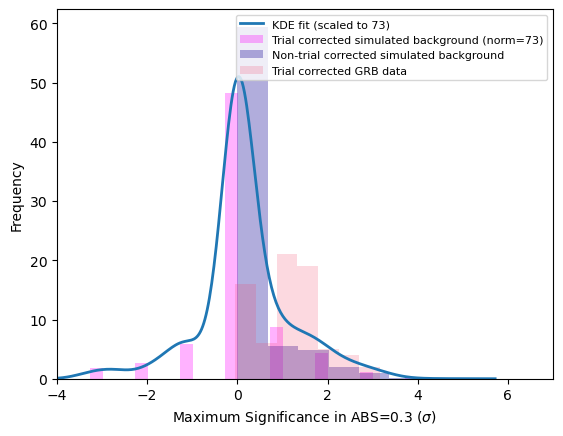

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import kstest, gaussian_kde, chi2,norm

# ==========================
# CONFIG
# ==========================
n_norm = 73  
PSF = [0.3]
j = 2
sig_name = 'sigma_post'
Fisher_T_statistics = {'PSF': [], 'T_stat': [], 'n_elem': [], 'Crit_val': []}

def normal_fixedA(x, mu, sigma, A0):
    """Gaussian with amplitude A0 fixed externally."""
    return A0 * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

for i in PSF:
    name_1 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free.csv'
    df_1 = pd.read_csv(name_1)

    name_2 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed.csv'
    df_2 = pd.read_csv(name_2)

    name_3 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free_data.csv'
    df_3 = pd.read_csv(name_3)

    name_4 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed_data.csv'
    df_4 = pd.read_csv(name_4)

    j = j + 1
    data = df_1[sig_name]

    # Describing the data
    mu = data.mean()
    std = data.std()
    S = data.skew()
    K = data.kurt()
    Tstat, p_value = kstest(data, 'norm', args=(mu, std))

    hist, bins = np.histogram(data, bins=8, density=True)
    A0 = hist.max()
    mu0 = data.mean()
    sigma0 = data.std()
    centers = 0.5 * (bins[:-1] + bins[1:]) 
    popt, pcov = curve_fit(
        lambda x, mu, sigma: normal_fixedA(x, mu, sigma, A0),
        centers,
        hist,
        p0=[mu0, sigma0]
    )
    mu_fit, sigma_fit = popt
    x_fit = np.linspace(centers.min(), centers.max(), 2000)

    # --- Non-parametric density estimate and visualization ---
    kde = gaussian_kde(data, bw_method=0.35)  
    x_kde = np.linspace(data.min() - 1, data.max() + 1, 400)
    y_kde = kde(x_kde)

    def pdf(x):
        return float(kde([x]))
    p_val_right = scipy.integrate.quad(pdf, 3, np.inf, limit=200)[0]
    print('The probability of values >3 sigma (non-parametric):', p_val_right)
    print('Directly from data:', len(data[data > 3]) / len(data))

    # Overlay the KDE curve (scaled by n_norm)
    plt.plot(
        x_kde,
        y_kde * n_norm,
        lw=2,
        label=f'KDE fit (scaled to {n_norm})'
    )

    # Histograms (scaled by n_norm)
    plt.hist(
        data, bins=bins,
        color='magenta',
        alpha=0.3,
        weights=np.ones(len(data)) * (n_norm/len(data)),
        label=f'Trial corrected simulated background (norm={n_norm})',
        width=0.3
    )

    df_2[sig_name].hist(
        bins=7,
        color=f'#{j}e32a8',
        alpha=0.4,
        weights=np.ones(len(df_2)) * (n_norm/len(df_2)),
        label='Non-trial corrected simulated background'
    )

    df_3[sig_name].hist(
        bins=7,
        color=f'#f{j}4266',
        alpha=0.2,
        weights=np.ones(len(df_3)) * (n_norm/len(df_3)),
        label='Trial corrected GRB data'
    )

    # Labels, legend, limits
    plt.grid(False)
    plt.legend(fontsize=8)
    plt.xlim([-4, 7])
    plt.ylabel('Frequency')
    plt.xlabel(fr'Maximum Significance in ABS={i} ($\sigma$) ')

    # Save with transparent background
    plt.savefig(f"plots/PSF{i}_wData.png", dpi=300, bbox_inches='tight')
    plt.show()

# Collect Fisher test results
Fisher_Test = pd.DataFrame(Fisher_T_statistics)

In [6]:
path='/lustre/hawcz01/scratch/userspace/jorgeamontes/GRB_KN/data/ULs/config/Data/GRB_List_z=0.csv'
path_FERMI='/lustre/hawcz01/scratch/userspace/smfraijac/Catalogs/Fermi/GRBsList_allDataBase.csv'
from astropy.time import Time
import numpy as np
from astropy.time import Time

times = pd.read_csv(path)
FERMI= pd.read_csv(path_FERMI)
# Convertir columna TRIG MJD a GPS
t = Time(times['TRIG MJD'].values, format='mjd', scale='utc')
times['GPS trigger'] = t.gps

# Calcular diferencia en horas
diff_hours = (times['Tstart (GPS)'] - times['GPS trigger']) / 3600
diff_hours_2= (times['Tstop (GPS)'] - times['GPS trigger']) / 3600
times['Tstart (h)'] = np.where(
    diff_hours < 0,
    0,
    diff_hours
)


In [ ]:
DF=pd.merge(df_3,times,left_on='GRB',right_on='Name',how='inner')





DF[['GRB','sigma_post','transit','Tstart (h)']]
DF['Tstart (h)'] = DF.apply(
    lambda row: row['Tstart (h)'] + 24 if row['transit'] =='transit_2' else row['Tstart (h)'],
    axis=1
)
DF_1_2sig=DF[(DF['sigma_post']>1)&(DF['sigma_post']<2)][['GRB','sigma_post','transit','Tstart (h)']]
DF_1sig=DF[(DF['sigma_post']<1)][['GRB','sigma_post','transit','Tstart (h)']]
DF_1_4sig=DF[(DF['sigma_post']>1)&(DF['sigma_post']<5)][['GRB','sigma_post','transit','Tstart (h)']]
# DF_1_2sig[DF_1_2sig['Tstart (h)']<5]
DF_1_2sig['Tstart (h)']
# DF_1_2sig.hist(bins=35)
DF

,GRB,transit,seed,ra_max,dec_max,max_sigma,region_size_deg,trials_factor,p_pre,p_post,...,flnc_sbpl_statistic,bcatalog,scatalog,last_modified,Unnamed: 307,Trigger_time(mjd),Fermi_Name,z_wo_pseudo,GPS trigger,Tstart (h)
0,GRB150101641,transit_1,GRB150101641_transit_1FINAL_C0,187.822266,-11.148899,1.355704,0.3,1.000000,0.087597,0.087597,...,Castor C-STAT,3,3,2018-07-02 14:07:15.00,NaN,57023.641371,GRB150101641,0.134,1.104161e+09,18.592370
1,GRB150101641,transit_2,GRB150101641_transit_2FINAL_C0,187.734375,-10.996861,1.118895,0.3,1.000000,0.131592,0.131592,...,Castor C-STAT,3,3,2018-07-02 14:07:15.00,NaN,57023.641371,GRB150101641,0.134,1.104161e+09,42.592370
2,GRB150110923,transit_1,GRB150110923_transit_1FINAL_C0,289.599609,32.664141,0.971536,0.3,1.000000,0.165641,0.165641,...,Castor C-STAT,3,3,2018-07-02 14:10:11.00,NaN,57032.922592,GRB150110923,0.000,1.104963e+09,17.049469
3,GRB150819440,transit_2,GRB150819440_transit_2FINAL_C0,58.930664,39.935668,2.074497,0.5,2.777778,0.019017,0.051935,...,Castor C-STAT,3,3,2018-07-06 13:48:52.00,NaN,57253.439809,GRB150819440,0.000,1.124016e+09,24.000000
4,GRB151229285,transit_1,GRB151229285_transit_1FINAL_C0,329.589844,-20.941949,0.307932,0.3,1.000000,0.379067,0.379067,...,Castor C-STAT,3,3,2018-07-08 18:12:21.00,NaN,57385.285046,GRB151229285,0.000,1.135407e+09,13.638624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,GRB230228244,transit_2,GRB230228244_transit_2FINAL_C0,18.660807,44.647509,1.271915,0.3,1.000000,0.101702,0.101702,...,PSTAT,3,5,2024-12-20 00:03:15.00,NaN,60003.243648,GRB230228244,0.000,1.361599e+09,36.353557
69,GRB230512269,transit_1,GRB230512269_transit_1FINAL_C0,295.136719,38.538976,1.082038,0.3,1.000000,0.139618,0.139618,...,PSTAT,3,5,2024-12-21 18:17:57.00,NaN,60076.269276,GRB230512269,0.000,1.367908e+09,1.274330
70,GRB230512269,transit_2,GRB230512269_transit_2FINAL_C0,295.708008,38.300922,1.153663,0.3,1.000000,0.124319,0.124319,...,PSTAT,3,5,2024-12-21 18:17:57.00,NaN,60076.269276,GRB230512269,0.000,1.367908e+09,25.274330
71,GRB230812790,transit_1,GRB230812790_transit_1FINAL_C0,249.103563,48.043367,0.949943,0.3,1.000000,0.171071,0.171071,...,PSTAT,3,5,2024-12-22 13:48:04.00,NaN,60168.790417,GRB230812790,0.360,1.375902e+09,3.868597


In [19]:
DF_1_4sig['sigma_post'] = DF_1_4sig['sigma_post'].round(2)
DF_1_4sig[['GRB','sigma_post','transit']].to_latex("DF_1sig_table.tex", index=False) 

/tmp/ipykernel_4085334/1738885616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs.dropna(inplace=True)
/tmp/ipykernel_4085334/1738885616.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24


NameError: name 'Tstart_FERMI' is not defined

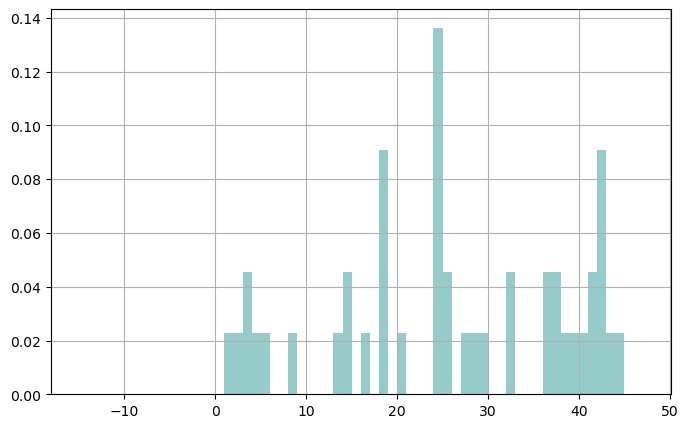

In [9]:
# Limpieza de datos

GRBs_sample=DF_1_4sig['GRB'].to_list()
Fermi_wo_GRBs=FERMI[~FERMI['GRB'].isin(GRBs_sample)]
GRBList_df=DF
Fermi_wo_GRBs.dropna(inplace=True)

# Cálculo de la segunda órbita y combinación de tiempos
Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24
Tstart_FERMI_no = Fermi_wo_GRBs['second_transit'].to_list() + Fermi_wo_GRBs['Tent-T0'].to_list()

# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
DF_1_4sig['Tstart (h)'].hist(
    bins=np.arange(-15,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–4 $\sigma$)', 
    color='#8ac6c3'
)
plt.hist(
    Tstart_FERMI, 
    bins=np.arange(-15,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)
plt.hist(
    Tstart_FERMI_no, 
    bins=np.arange(-15,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in the 1-4 $\sigma$ range', 
    color='#14213d', 
    alpha=0.7
)

# Histograma de los GRBs analizados en tu estudio


# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title('Comparison Short Fermi-GBM detected GRBs with GRBs in this sample', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


Si quitamos nuestra muestra de Fermi:
Fermi['GRBs']

In [10]:
# --- Crear listas de pares (GRB, transit) para cada muestra ---
exclude_pairs_4 = DF_1_4sig[['GRB', 'transit']].apply(tuple, axis=1).tolist()
exclude_pairs_2 = DF_1_2sig[['GRB', 'transit']].apply(tuple, axis=1).tolist()

# --- Crear columna auxiliar con pares (GRB, transit) ---
FERMI_combined['pair'] = list(zip(FERMI_combined['GRB'], FERMI_combined['transit']))

# --- Filtrar por cada caso ---
FERMI_wo_GRBs_4 = FERMI_combined[~FERMI_combined['pair'].isin(exclude_pairs_4)].copy()
FERMI_wo_GRBs_2 = FERMI_combined[~FERMI_combined['pair'].isin(exclude_pairs_2)].copy()

# --- Eliminar columna auxiliar ---
FERMI_wo_GRBs_4.drop(columns='pair', inplace=True)
FERMI_wo_GRBs_2.drop(columns='pair', inplace=True)

NameError: name 'FERMI_combined' is not defined

/tmp/ipykernel_2971777/4142291716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs.dropna(inplace=True)
/tmp/ipykernel_2971777/4142291716.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24


Estos GRBs tienen o no redshift


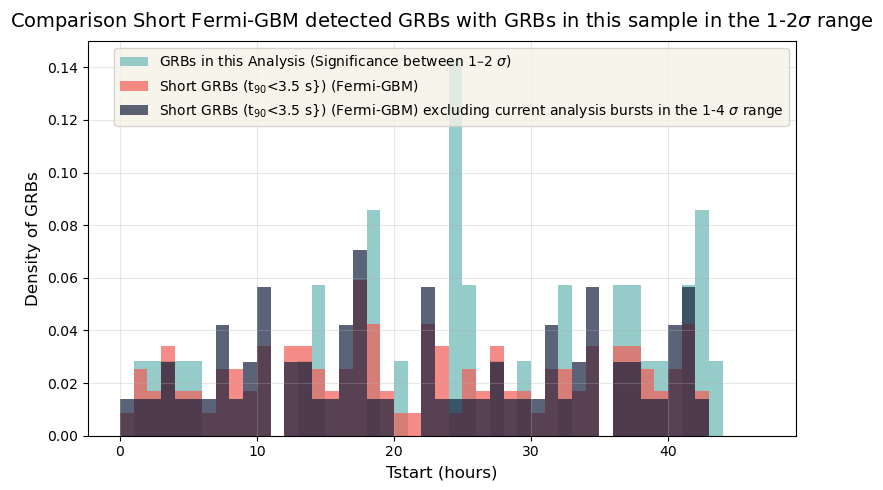

In [ ]:
# Limpieza de datos

GRBs_sample=DF_1_2sig['GRB'].to_list()
Fermi_wo_GRBs=FERMI[~FERMI['GRB'].isin(GRBs_sample)]
GRBList_df=DF
Fermi_wo_GRBs.dropna(inplace=True)

# Cálculo de la segunda órbita y combinación de tiempos
Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24
Tstart_FERMI_no = Fermi_wo_GRBs['second_transit'].to_list() + Fermi_wo_GRBs['Tent-T0'].to_list()

# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
DF_1_2sig['Tstart (h)'].hist(
    bins=np.arange(0,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–2 $\sigma$)', 
    color='#8ac6c3'
)
plt.hist(
    Tstart_FERMI, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)
plt.hist(
    Tstart_FERMI_no, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in the 1-4 $\sigma$ range', 
    color='#14213d', 
    alpha=0.7
)

# Histograma de los GRBs analizados en tu estudio


# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title(r'Comparison Short Fermi-GBM detected GRBs with GRBs in this sample in the 1-2$\sigma$ range', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


      Next I wil plot all Fermi GBM GRBs that passed through the  HAWC FOV, followed by the complete GRBs sample analyzed in this study, and finally, the subset of  GRBs with a sifnificance level between  1 and 2 sigma.

/tmp/ipykernel_2971777/1446081212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fermi_wo_GRBs.dropna(inplace=True)


Estos GRBs tienen o no redshift


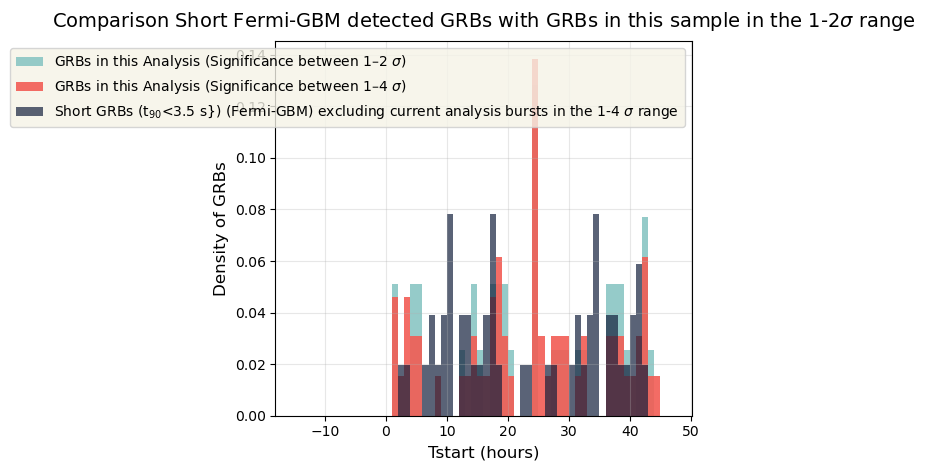

In [ ]:

GRBs_sample=DF_1_4sig['GRB'].to_list() # Lista de TODOS loS GRBs de mi análisis
Fermi_wo_GRBs=FERMI[~FERMI['GRB'].isin(GRBs_sample)]#odos los GRBs de Fermi GBM  del 2015 al 2024 quitando TODOS los destellos que ANALIZO
GRBList_df=DF
Fermi_wo_GRBs.dropna(inplace=True)

DF_1_2sig['Tstart (h)'].hist(
    bins=np.arange(0,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–2 $\sigma$)', 
    color='#8ac6c3'
)
DF_1_4sig['Tstart (h)'].hist(
    bins=np.arange(-15,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–4 $\sigma$)', 
    color='#f25c54'
)
plt.hist(
    Tstart_FERMI_no, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in the 1-4 $\sigma$ range', 
    color='#14213d', 
    alpha=0.7
)
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title(r'Comparison Short Fermi-GBM detected GRBs with GRBs in this sample in the 1-2$\sigma$ range', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()

# Limpieza de datos
Fermi_wo_GRBs.dropna(inplace=True)

# Cálculo de la segunda órbita y combinación de tiempos
Fermi_wo_GRBs['second_transit'] = Fermi_wo_GRBs['Tent-T0'] + 24
Tstart_FERMI_no = Fermi_wo_GRBs['second_transit'].to_list() + Fermi_wo_GRBs['Tent-T0'].to_list()

# Figura y ejes
plt.figure(figsize=(8, 5))

# Histograma de GRBs cortos observados por Fermi
DF_1_2sig['Tstart (h)'].hist(
    bins=np.arange(0,48,1), 
    density=True, 
    alpha=0.9, 
    label=r'GRBs in this Analysis (Significance between 1–2 $\sigma$)', 
    color='#8ac6c3'
)
plt.hist(
    Tstart_FERMI, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM)', 
    color='#f25c54', 
    alpha=0.7
)
plt.hist(
    Tstart_FERMI_no, 
    bins=np.arange(0,48,1), 
    density=True, 
    label=r'Short GRBs (t$_{90}$<3.5 s}) (Fermi-GBM) excluding current analysis bursts in 1-2 ', 
    color='#14213d', 
    alpha=0.7
)

# Histograma de los GRBs analizados en tu estudio


# Personalización del gráfico
plt.xlabel('Tstart (hours)', fontsize=12)
plt.ylabel('Density of GRBs', fontsize=12)
plt.title(r'Comparison Short FErmi-GBM detected GRBs with GRBs in this analysis ranging from 1 to 2 $\sigma$ significance', fontsize=14, pad=10)
plt.legend(facecolor='#f5f3e7')
plt.grid(alpha=0.3)
plt.tight_layout()
print('Estos GRBs tienen o no redshift')
# Mostrar figura
plt.show()


In [ ]:
len(FERMI),len(Fermi_wo_GRBs),len(DF_1_2sig['GRB'].drop_duplicates()),len(DF['GRB'].drop_duplicates())


(68, 39, 29, 42)

In [ ]:
print('De aquí los que tienen kilonova son GRB 170817A, 160821B y 150101B.')
grb_w_KN=['GRB150101641','GRB160821937','GRB170817529']
for grb in grb_w_KN:
    t=DF[DF['GRB']==grb]['Tstart (h)'].values[0]
    print(f'El tiempo de entrada al FOV de HAWC del {grb} es {t}')

De aquí los que tienen kilonova son GRB 170817A, 160821B y 150101B.
El tiempo de entrada al FOV de HAWC del GRB150101641 es 18.592370000018015
El tiempo de entrada al FOV de HAWC del GRB160821937 es 3.4779630555709202
El tiempo de entrada al FOV de HAWC del GRB170817529 es 8.202368055582047


13

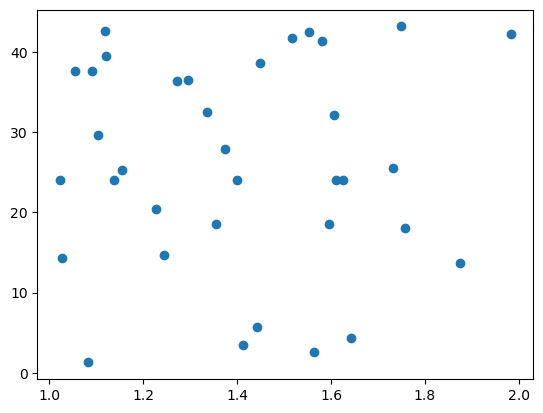

In [ ]:
plt.scatter(DF_1_2sig['sigma_post'],DF_1_2sig['Tstart (h)'])
len(DF_1_2sig[(DF_1_2sig['sigma_post']>1.4)&(DF_1_2sig['Tstart (h)']>12)])

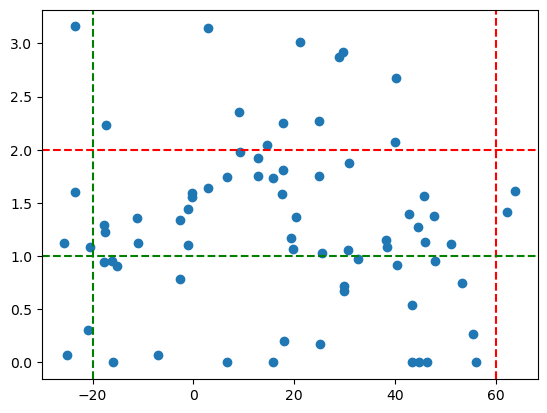

In [ ]:
Sig=DF['max_sigma']
Zenith=abs(DF['dec_max']-19)
Dec=DF['dec_max']
plt.axvline(x=60, color='r', linestyle='--', label='Umbral 0.5')
plt.axvline(x=-20, color='g', linestyle='--', label='Umbral 0.5')
plt.axhline(y=2, color='r', linestyle='--', label='Umbral 0.5')
plt.axhline(y=1, color='g', linestyle='--', label='Umbral 0.5')
plt.scatter(Dec,Sig)

<Axes: >

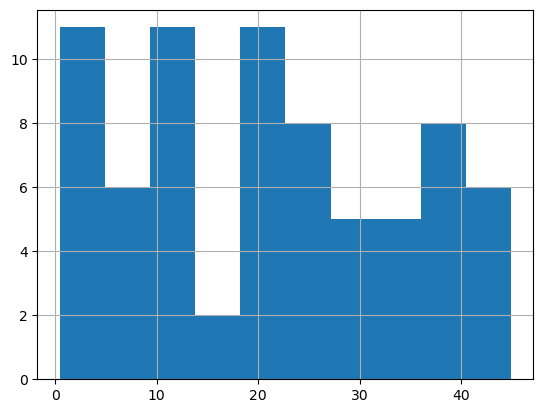

In [ ]:
Zenith.hist()

In [ ]:
DF[(DF['max_sigma']<2.5)&(DF['max_sigma']>2.0)]

,GRB,transit,seed,ra_max,dec_max,max_sigma,region_size_deg,trials_factor,p_pre,p_post,...,flnc_sbpl_statistic,bcatalog,scatalog,last_modified,Unnamed: 307,Trigger_time(mjd),Fermi_Name,z_wo_pseudo,GPS trigger,Tstart (h)
3,GRB150819440,transit_2,GRB150819440_transit_2FINAL_C0,58.930664,39.935668,2.074497,0.50,2.777778,0.019017,0.051935,...,Castor C-STAT,3,3,2018-07-06 13:48:52.00,NaN,57253.439809,GRB150819440,0.0,1.124016e+09,24.000000
12,GRB170206453,transit_2,GRB170206453_transit_2FINAL_C0,212.255859,14.670223,2.043394,0.85,8.027778,0.020507,0.153237,...,Castor C-STAT,3,3,2017-02-23 15:57:38.00,NaN,57790.452751,GRB170206453,0.0,1.170414e+09,24.000000
16,GRB170403583,transit_2,GRB170403583_transit_2FINAL_C0,259.277344,17.700204,2.250479,0.70,5.444444,0.012209,0.064694,...,Castor C-STAT,3,3,2019-03-18 21:16:23.00,NaN,57846.582845,GRB170403583,0.0,1.175263e+09,41.769501
32,GRB180418281,transit_2,GRB180418281_transit_2FINAL_C0,170.419922,24.994170,2.265931,0.30,1.000000,0.011728,0.011728,...,Castor C-STAT,3,3,2018-10-29 16:16:45.00,NaN,58226.280628,GRB180418281,0.0,1.208069e+09,42.081311
38,GRB180805543,transit_2,GRB180805543_transit_2FINAL_C0,25.532227,-17.426323,2.237625,0.30,1.000000,0.012623,0.012623,...,PSTAT,3,5,2024-12-18 14:11:01.00,NaN,58335.543478,GRB180805543,0.0,1.217509e+09,44.393468
49,GRB201214672,transit_1,GRB201214672_transit_1FINAL_C0,187.690430,9.064839,2.355880,0.30,1.000000,0.009239,0.009239,...,PSTAT,3,5,2024-12-17 16:28:41.00,NaN,59197.672067,GRB201214672,0.0,1.291997e+09,18.246773


In [ ]:
Fisher_Test['p_val (Fisher)']=Fisher_Test.apply(lambda row: chi2.sf(row['T_stat'],2*row['n_elem']),axis=1)
Fisher_Test

,PSF,T_stat,n_elem,Crit_val,p_val (Fisher)


The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.02609177192147948
and directly from data is: 0.0036383682469680267


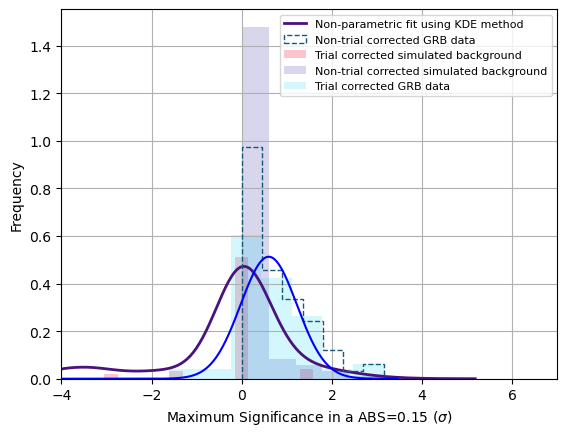

The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.04575935011545966
and directly from data is: 0.009475539885412075


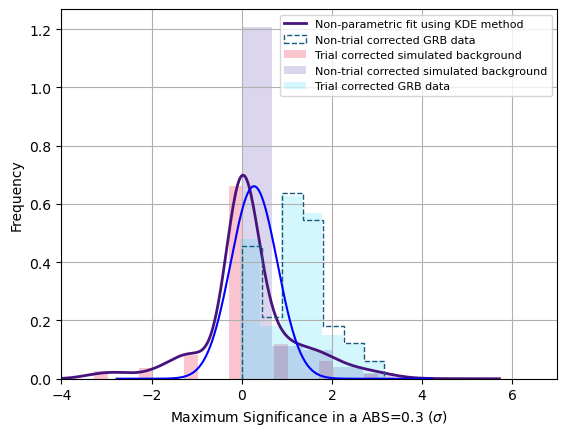

The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.09875735895766946
and directly from data is: 0.035706240144176615


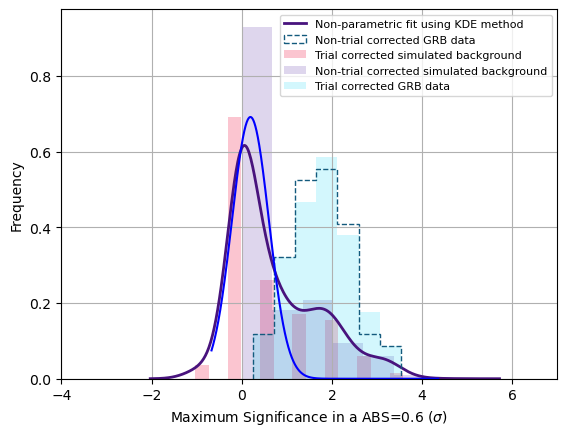

In [ ]:
#now this is my sample but how can I do this plote with no backgrounf and ith dark mode so the lines are all is white import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import kstest,gaussian_kde,chi2
PSF = [0.15,0.3,0.6]
j = 2
sig_name = 'sigma_post'
Fisher_T_statistics={'PSF':[],'T_stat':[],'n_elem':[],'Crit_val':[]}
def normal_fixedA(x, mu, sigma, A0):
    """Gaussian with amplitude A0 fixed externally."""
    return A0 * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

for i in PSF:
    name_1 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free.csv'
    df_1 = pd.read_csv(name_1)

    name_2 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed.csv'
    df_2 = pd.read_csv(name_2)

    
    name_3 = f'Files/Max/grb_all_seed_maxima_PSF{i}_free_data.csv'
    df_3 = pd.read_csv(name_3)
    
    name_4 = f'Files/Max/grb_all_seed_maxima_PSF{i}_fixed_data.csv'
    df_4 = pd.read_csv(name_4)
    
    j = j + 1
    data = df_1[sig_name]

    # Describing  the data
    mu = data.mean()
    std = data.std()
    S = data.skew()
    K = data.kurt()
    Tstat, p_value = kstest(data, 'norm', args=(mu, std))

    hist, bins = np.histogram(data,bins=8,density=True)
    A0 = hist.max()
    mu0 = data.mean()
    sigma0 = data.std()
    centers = 0.5 * (bins[:-1] + bins[1:]) 
    popt, pcov = curve_fit(
        lambda x, mu, sigma: normal_fixedA(x, mu, sigma, A0),
        centers,
        hist,
        p0=[mu0, sigma0]
    )
    mu_fit, sigma_fit = popt
    x_fit = np.linspace(centers.min(), centers.max(), 2000)

    # --- Non-parametric density estimate and visualization ---

    # Build a kernel-density estimate from the same data
    kde = gaussian_kde(data, bw_method=0.35)  # or 'silverman' / float for bandwidth
    x_kde = np.linspace(data.min() - 1, data.max() + 1, 400)
    y_kde = kde(x_kde)
    def pdf(x):
        return(float(kde([x])))
    p_val_right=scipy.integrate.quad(pdf,3,np.inf,limit=200)[0]
    p_val_right=scipy.integrate.quad(pdf,2,3,limit=200)[0]
    p_val=()
    print('The probability of having values greater than 3 sigma with the non-parametric distribution  is:',p_val_right)
    print('and directly from data is:',len(data[data>3])/len(data))
    # Overlay the KDE curve
    plt.plot(
        x_kde,
        y_kde,
        color='#48137d',
        lw=2,
        label='Non-parametric fit using KDE method'
    )
    #gaussian fit

    df_4[sig_name].hist(
        bins=7,
        histtype='step',            # <-- outline only
        linewidth=1,  
        ls='dashed',# optional: thicker lines
        color='#135a7d',
        label='Non-trial corrected GRB data',
        density=True
    )
    ########################################################################
    # Fisher Test
    ########################################################################
    sigma_lim=3
    def PVal(x_data):
        p_val=-2*np.log(scipy.integrate.quad(kde,x_data,np.inf,limit=200)[0])
        return p_val
    GRB_data=df_4[df_4[sig_name]<sigma_lim][sig_name]
    Fisher_statistic=GRB_data.apply(PVal).sum();n_elem=len(GRB_data) 
    # #Finding the critical value
    Crit_val=chi2.ppf(0.95,2*n_elem)
    Fisher_T_statistics['PSF'].append(i)
    Fisher_T_statistics['T_stat'].append(Fisher_statistic)
    Fisher_T_statistics['n_elem'].append(n_elem)
    Fisher_T_statistics['Crit_val'].append(Crit_val)
    plt.plot(x_fit,
            normal_fixedA(x_fit, mu_fit, sigma_fit, A0),
            "b-")

    # plt.hist(data,bins=bins,
    #         color=f'#f{j}4266',
    #         alpha=0.3,
    #         label=fr'max(PSF,Fermi_error),S={S:.2f},K={K:.2f},stat_KS={Tstat:.2f},p$_v$={p_value:.2f}',
    #         density=True,width=0.3)
    plt.hist(data,bins=bins,
            color=f'#f{j}4266',
            alpha=0.3,
            label=fr'Trial corrected simulated background',
            density=True,width=0.3)

    df_2[                  sig_name].hist(bins=7,
                        color=f'#{j}e32a8',  
                        alpha=0.2,
                        label='Non-trial corrected simulated background',
    density=True)
    df_3[                  sig_name].hist(bins=7,
                        color=f'#27DAF5',  
                        alpha=0.2,
                        label='Trial corrected GRB data',
    density=True)
    plt.legend(fontsize='8')
    plt.xlim([-4,7])
    plt.ylabel('Frequency')
    plt.xlabel(fr'Maximum Significance in a ABS={i} ($\sigma$) ')
    plt.savefig(f"plots/PSF{i}_wData.png", dpi=300, bbox_inches='tight')
    plt.show()
Fisher_Test=pd.DataFrame(Fisher_T_statistics)

In [ ]:
from scipy.stats import norm
Fisher_Test['p_val (Fisher)']=Fisher_Test.apply(lambda row: chi2.sf(row['T_stat'],2*row['n_elem']),axis=1)
Fisher_Test['sig (Fisher)']=Fisher_Test.apply(lambda row: norm.isf(row['p_val (Fisher)']),axis=1)

Fisher_Test
Fisher_Test

,PSF,T_stat,n_elem,Crit_val,p_val (Fisher),sig (Fisher)
0,0.15,232.884582,71,170.809198,2.320864e-06,4.580362
1,0.30,268.437302,71,170.809198,7.786422e-10,6.038319
2,0.60,251.997052,70,168.612954,2.029692e-08,5.488249


In [ ]:
norm.sf(6.6)

2.0557889093995235e-11